In [1]:
import numpy as np
#import cvxpy as cp
import torch

In [2]:
from scipy.linalg import eigh
from scipy.stats import chi2

In [2]:
from matplotlib import pyplot as plt

In [3]:
from sklearn.linear_model import LogisticRegressionCV
#from sklearn.gaussian_process import GaussianProcessRegressor
#from sklearn.decomposition import KernelPCA
#from sklearn.gaussian_process.kernels import ConstantKernel, WhiteKernel, RBF
#from sklearn.linear_model import QuantileRegressor

In [4]:
import warnings
import tqdm

In [6]:
from .model import ConfoundingRobustEstimator

ImportError: attempted relative import with no known parent package

### Synthetic Data from Kallus 2018

Notes on data types:

- Only use torch tensor for `Y` and `r`
- For other data, use numpy array

In [6]:
beta0 = 2.5
beta0_t = -2
beta_x = np.asarray([0, .5, -0.5, 0, 0])
beta_x_t = np.asarray([-1.5, 1, -1.5, 1., 0.5])
beta_xi = 1
beta_xi_t = -2
beta_e_x = np.asarray([0, .75, -.5, 0, -1])
mu_x = np.asarray([-1, .5, -1, 0, -1]);

def generate_data(n):
    xi = (np.random.rand(n) > 0.5).astype(int)
    X = mu_x[None, :] + np.random.randn(n * 5).reshape(n, 5)
    eps = [np.random.randn(n) for t in (0, 1)]
    Y = np.array([
        X @ (beta_x + beta_x_t * t) + (beta_xi + beta_xi_t * t) * xi + (beta0 + beta0_t * t) + eps[t]
        for t in (0, 1)
    ])
    U = (Y[0, :] > Y[1, :]).astype(int)
    z = X @ beta_e_x
    e_x = np.exp(z) / (1 + np.exp(z))
    e_xu = (6 * e_x) / (4 + 5 * U + e_x * (2 - 5 * U))
    T = (np.random.rand(n) < e_xu).astype(int)
    Y = Y[T, range(n)]
    e_x = e_x * T + (1 - e_x) * (1 - T)
    e_xu = e_xu * T + (1 - e_xu) * (1 - T)
    return torch.tensor(Y), T, X, U, e_x, e_xu

def evaluate_policy(policy, n=1000):
    xi = (np.random.rand(n) > 0.5).astype(int)
    X = mu_x[None, :] + np.random.randn(n * 5).reshape(n, 5)
    eps = [np.random.randn(n) for t in (0, 1)]
    Y = np.array([
        X @ (beta_x + beta_x_t * t) + (beta_xi + beta_xi_t * t) * xi + (beta0 + beta0_t * t) + eps[t]
        for t in (0, 1)
    ])
    Y = torch.as_tensor(Y)
    pi = policy(X)
    Y = torch.sum(Y.T * pi, axis=1)
    return Y.mean()

In [153]:
beta0 = 2.5
beta0_t = -2
beta_x = np.asarray([0, .5, -0.5, 0, 0])
beta_x_t = np.asarray([-1.5, 1, -1.5, 1., 0.5])
beta_xi = 1
beta_xi_t = -2
beta_e_x = np.asarray([0, .75, -.5, 0, -1])
mu_x = np.asarray([-1, .5, -1, 0, -1]);

def generate_data_continuous(n):
    xi = (np.random.rand(n) > 0.5).astype(int)
    X = mu_x[None, :] + np.random.randn(n * 5).reshape(n, 5)
    eps = [np.random.randn(n) for t in (0, 1)]
    Y = np.array([
        X @ (beta_x + beta_x_t * t) + (beta_xi + beta_xi_t * t) * xi + (beta0 + beta0_t * t) + eps[t]
        for t in (0, 1)
    ])
    U = (Y[0, :] > Y[1, :]).astype(int)
    z = X @ beta_e_x
    e_x = np.exp(z) / (1 + np.exp(z))
    mu_xu = (6 * e_x) / (4 + 5 * U + e_x * (2 - 5 * U))
    mu_xu = np.clip(mu_xu, 1e-6, 1 - 1e-6)
    unif = np.random.rand(n)
    a, b = 4 * mu_xu + 1, 4 * (1 - mu_xu) + 1
    T = (1 - ber) * beta.rvs(a, b) + ber * unif
    e_xu = beta.pdf(T, a, b)
    Y = (1 - T) * Y[0, :] + T * Y[1, :]
    Y = torch.as_tensor(Y)
    return Y, T, X, U, e_x, e_xu

def evaluate_policy_continuous(policy, n=1000, requires_grad=False):
    xi = (np.random.rand(n) > 0.5).astype(int)
    X = mu_x[None, :] + np.random.randn(n * 5).reshape(n, 5)
    eps = [np.random.randn(n) for t in (0, 1)]
    Y = np.array([
        X @ (beta_x + beta_x_t * t) + (beta_xi + beta_xi_t * t) * xi + (beta0 + beta0_t * t) + eps[t]
        for t in (0, 1)
    ])
    T = policy(X).rsample() if requires_grad else policy(X).sample()
    Y = torch.as_tensor(Y) if isinstance(T, torch.Tensor) else Y
    Y = (1 - T) * Y[0, :] + T * Y[1, :]
    return Y.mean()

In [7]:
n = 1000
np.random.seed(0)
Y, T, X, U, e_x, e_xu = generate_data(n)

In [8]:
def toy_policy(X):
    z = torch.as_tensor(X) @ torch.as_tensor(beta_e_x)
    e_x = torch.exp(z) / (1 + torch.exp(z))
    return torch.stack([e_x, 1. - e_x]).T

# def zero_policy(X):
#    return np.zeros(X.shape[0], dtype=int)

### Estimate Propensity Score (Conditional Density Estimation)

#### Discrete Case

In [9]:
# Logistic regression is already quite good

model = LogisticRegressionCV().fit(X, T)
e_xx = model.predict_proba(X)[range(n), T]

np.mean(np.abs(e_xx - e_xu))

0.04417433219435932

In [10]:
p_t = e_xx

### Ground Truth

In [11]:
evaluate_policy(toy_policy, n=1000000)

tensor(3.6258, dtype=torch.float64)

### IPW estimator

In [12]:
def IPW(Y, T, X, p_t, policy):
    n = p_t.shape[0]
    r = Y * policy(X)[range(n), T]
    est = torch.mean(r / torch.as_tensor(p_t))
    return est

In [13]:
est_ipw = IPW(Y, T, X, p_t, toy_policy)

In [14]:
est_ipw

tensor(3.4380, dtype=torch.float64)

### Hajek estimator

In [15]:
def Hajek(Y, T, X, p_t, policy, return_w=False):
    n = p_t.shape[0]
    r = Y * policy(X)[range(n), T]
    p_t_new = np.empty_like(p_t)
    for t in set(T):
        p_t_new[T==t] = p_t[T==t] * np.mean((T==t) / p_t)
    est = torch.mean(r / torch.as_tensor(p_t_new))
    return est

In [16]:
est_hajek = Hajek(Y, T, X, p_t, toy_policy)

In [17]:
est_hajek

tensor(3.7397, dtype=torch.float64)

### Implement Confounding Robust Inference

In [37]:
def confoundingRobustEstimator(
    Y, T, X, p_t, policy,
    D=200,
    lambd=1.5, 
    gamma=0.5,
    alpha=0.05,
    kernel=RBF(),
    sigma2=1.0,
    hard_kernel_const=False,
    f_divergence='KL', 
    hajek_const=False,
    kernel_const=False,
    quantile_const=False,
    tan_box_const=False,
    lr_box_const=False,
    f_const=False,
    return_w=False,
):
    n = T.shape[0]
    pi = policy(X)[range(n), T] 
    r = Y * pi
    Y_np, r_np, pi_np = map(lambda tensor: tensor.data.numpy(), (Y, r, pi))
    
    p_t_original = p_t
    p_t = normalize_p_t(p_t, T)  # normalization for simply guaranteeing the feasibility for Hajek constraints
        
    with warnings.catch_warnings():  # to avoid user warning about multiplication operator with `*` and `@`
        warnings.simplefilter("ignore")
        w = cp.Variable(n)
        constraints = [np.zeros(n) <= w]
        if hajek_const:
            constraints.extend(get_hajek_constraint(w, T, p_t))
        if kernel_const:
            constraints.extend(get_kernel_constraint(w, T, X, p_t, alpha, sigma2, kernel, D, hard_kernel_const))
        if quantile_const:
            assert f_const == False, "quantile constraint is only for box constraints"
            constraints.extend(get_quantile_constraint(w, Y_np, pi_np, T, X, p_t, lambd))
        if tan_box_const:
            constraints.extend(get_tan_box_constraint(w, p_t, p_t_original, lambd))
        if lr_box_const:
            constraints.extend(get_likelihood_ratio_box_constraint(w, p_t, lambd))
        if f_const:
            constraints.extend(get_f_constraint(w, p_t, gamma, f_divergence))
            constraints.append(cp.sum(-cp.log(w * p_t)) <= 0.1)
        objective = cp.Minimize(cp.sum(r_np * w))
        problem = cp.Problem(objective, constraints)
        problem.solve(solver=cp.MOSEK if f_const else cp.ECOS)
        
        print(problem.status)
    w = w.value
    est = torch.mean(torch.as_tensor(w) * r)
    return (est, w) if return_w else est

def normalize_p_t(p_t, T):
    p_t_new = np.empty_like(p_t)
    for t in set(T):
        p_t_new[T==t] = p_t[T==t] * np.mean((T==t) / p_t)
    return p_t_new

def fit_gp_kernel(Y, T, X):
    TX = np.concatenate([T[:, None], X], axis=1)
    TX /= TX.std(axis=0)[None, :]
    kernel = WhiteKernel() + ConstantKernel() * RBF()
    model = GaussianProcessRegressor(kernel=kernel).fit(TX[:1000], Y[:1000])
    return model.kernel_

def get_hajek_constraint(w, T, p_t):
    n = T.shape[0]
    constraints = []
    for t in set(T):
        constraints.append(cp.sum(w[T==t]) == n)
    return constraints

def get_kernel_constraint(w, T, X, p_t, alpha, sigma2, kernel, D, hard_kernel_const):
    n = T.shape[0]
    D = min(D, n)
    M, u, Cov_z, D = getGPQC(T, X, p_t, D, sigma2, kernel)
    chi2_bound = chi2(df=D).ppf(1 - alpha)
    
    z = cp.Variable(D)
    if hard_kernel_const:
        constraints = [np.zeros(D) ==  M @ w - u]
    else:
        constraints = [
            z == M @ w - u,
            cp.sum(z ** 2 / Cov_z) <= chi2_bound,
        ]
    return constraints

def getGPQC(T, X, p_t, D, sigma2, kernel):
    n = T.shape[0]
    TX = np.concatenate([T[:, None], X], axis=1)
    TX /= TX.std(axis=0)[None, :]
    K = kernel(TX, TX)
    S, V = eigh(K, subset_by_index=[n - D, n-1])
    S, V = cutoff_neg_eigvals(S, V)
    
    M = np.diag(S / (S + sigma2)) @ V.T @ np.diag(p_t)
    u = np.diag(S / (S + sigma2)) @ V.T @ np.ones(n)
    Cov_z = S - S ** 2 / (S + sigma2)

    return M, u, Cov_z, u.shape[0]

def cutoff_neg_eigvals(S, V):
    V = V[:, S > 1e-6]
    S = S[S > 1e-6]
    return S, V

def get_quantile_constraint(w, Y_np, pi_np, T, X, p_t, lambd):
    USE_KERNEL = False
    n = T.shape[0]
    TX = np.concatenate([T[:, None], X], axis=1)
    TX /= TX.std(axis=0)[None, :]
    if USE_KERNEL:
        kernel = fit_gp_kernel(Y, T, X)
        TX = KernelPCA(30).fit_transform(TX)
    Q = QuantileRegressor(quantile=1. / (lambd + 1), alpha=0.).fit(TX, Y).predict(TX) # any regressor will do, 
    ### Carveat: np.ones(n) * w is NOT the element-wise product in cvxpy!!!
    return [cp.scalar_product(pi_np * Q, w) == np.sum(pi_np * Q / p_t)]

def get_tan_box_constraint(w, p_t, p_t_original, lambd):
    # p_t does not always satisfy p_t < 1, therefore, we use p_t_original
    # to construct box constraint for w_original and rescale it for w.
    a_original = 1 + 1 / lambd * (1 / p_t_original - 1)
    b_original = 1 + lambd * (1 / p_t_original - 1)
    a = a_original * p_t_original / p_t
    b = b_original * p_t_original / p_t
    return [a <= w, w <= b]

def get_likelihood_ratio_box_constraint(w, p_t, lambd):
    a = 1 / (lambd * p_t)
    b = lambd / p_t
    return [a <= w, w <= b]

def get_f_constraint(w, p_t, gamma, f):
    EPS = 1e-4
    n = p_t.shape[0]
    f = {
        'KL': lambda u: - cp.entr(u),
        'inverse KL': lambda u: - cp.log(u),
        'Jensen-Shannon': lambda u: - 0.5 * (cp.entr(u) + cp.log(u)),
        'squared Hellinger': lambda u: u - 2 * cp.sqrt(u) + 1,
        'Pearson chi squared': lambda u: cp.square(u) - 1,
        'Neyman chi squared': lambda u: cp.inv_pos(u) - 1,
        'total variation': lambda u: 0.5 * cp.abs(u - 1),
    }[f]
    ### Carveat: np.ones(n) * w is NOT the element-wise product in cvxpy!!!
    constraints = [
        cp.sum(f(cp.multiply(w, p_t))) <= gamma * n,
        #cp.sum(-cp.log(cp.multiply(w, p_t))) <= 0.1,
        cp.scalar_product(w, p_t) == n,
        #EPS * np.ones(n) <= w,
    ]
    return constraints

x = cp.Variable(10)
objective = cp.Minimize(cp.sum(np.arange(10) * x))
constraints = [np.zeros(10) <= x, cp.sum(x) == 10, cp.sum(-cp.log(np.ones(10) * x)) <= 1]
problem = cp.Problem(objective, constraints)
problem.solve()

In [ ]:
{
    'KL': lambda u: - cp.entr(u),
    'inverse KL': lambda u: - cp.log(u),
    'Jensen-Shannon': lambda u: - 0.5 * (cp.entr(u) + cp.log(u)),
    'squared Hellinger': lambda u: u - 2 * cp.sqrt(u) + 1,
    'Pearson chi squared': lambda u: cp.square(u) - 1,
    'Neyman chi squared': lambda u: cp.inv_pos(u) - 1,
    'total variation': lambda u: 0.5 * cp.abs(u - 1),
}

In [151]:
est, w = confoundingRobustEstimator(
    Y, T, X, p_t, toy_policy,
    D=200,
    lambd=1.5, 
    gamma=0.01,
    alpha=0.05,
    hard_kernel_const=False,
    f_divergence='total variation', 
    hajek_const=True,
    kernel_const=False,
    quantile_const=False,
    tan_box_const=False,
    lr_box_const=True,
    f_const=False,
    return_w=True
)

optimal


In [152]:
est

tensor(3.0305, dtype=torch.float64)

In [148]:
min(w), max(w)

(3.8456605667492336e-12, 207.97611535197518)

In [125]:
est_hajek

tensor(3.7397, dtype=torch.float64)

In [120]:
est

tensor(3.1208, dtype=torch.float64)

In [115]:
p_t_ = normalize_p_t(p_t, T)
sum(w * p_t_), max(-np.log(w * p_t_))

(999.9999992247955, 3.497439249513266)

In [116]:
cp.sum(-cp.log(w * p_t)).value <= 0.1

False

In [50]:
# Guessing kernel with approximate solution
_, w_guess = confoundingRobustEstimator(
    Y, T, X, p_t, toy_policy, lambd=1.5,
    hajek_const=True, tan_box_const=True, return_w=True,
)
e_guess = p_t * w_guess - 1
gp_kernel = fit_gp_kernel(e_guess, T, X)
sigma2 = gp_kernel.k1.noise_level
kernel = gp_kernel.k2

optimal


In [315]:
est = confoundingRobustEstimator(
    Y, T, X, p_t, toy_policy,
    D=200,
    lambd=1.5, 
    gamma=0.5,
    alpha=0.05,
    sigma2=sigma2,
    kernel=kernel,
    hard_kernel_const=False,
    f_divergence='KL', 
    hajek_const=True,
    kernel_const=True,
    quantile_const=False,
    tan_box_const=True,
    lr_box_const=False,
    f_const=False,
)

optimal


In [316]:
est

tensor(3.3533, dtype=torch.float64)

def get_sigma2(p_t, p_t_original, lambd, tan_box_const, lr_box_const):
    # heuristically decide sigma2
    SCALE = 0.1  # <= 1, when chosen to be 1.0, it gives theoeretical upper bound
    sigma2 = float('inf')
    if tan_box_const:
        a_original = 1 + 1 / lambd * (1 / p_t_original - 1)
        b_original = 1 + lambd * (1 / p_t_original - 1)
        a = a_original * p_t_original / p_t
        b = b_original * p_t_original / p_t
        sigma2 = min(sigma2, np.mean((0.5 * (b - a) * p_t) ** 2))
    if lr_box_const:
        sigma2 = min(sigma2, np.mean((0.5 * (lambd - 1. / lambd)) ** 2))
    if sigma2 == float('inf'):
        sigma2 = 1.0   # just a guess
    return SCALE * sigma2

In [136]:
def confoundingRobustHajek(r, T, a, b, return_w=False):
    r_np = r.data.numpy()
    w = np.zeros_like(a)
    for t in set(T):
        r_t = r_np[T == t]
        a_t = a[T == t]
        b_t = b[T == t]
        with warnings.catch_warnings():  # to avoid user warning about multiplication operator with `*` and `@`
            warnings.simplefilter("ignore")
            w[T == t] = hajekLP(r_t, a_t, b_t, r.shape[0])
    if isinstance(r, torch.Tensor):
        est = torch.mean(torch.as_tensor(w) * r)
    else:
        est = np.mean(w * r_np)
    return (est, w) if return_w else est

def hajekLP(r, a, b, n):
    m = r.shape[0]
    w = cp.Variable(m)
    phi = cp.Variable()
    constraints = [
        np.zeros(m) <= w,
        0 <= phi,
        a * phi <= w,
        w <= b * phi,
        cp.sum(w) == n
    ]
    objective = cp.Minimize(cp.sum(r * w))
    problem = cp.Problem(objective, constraints)
    problem.solve()
    return w.value

In [137]:
def get_a_b(p_t, gamma):
    a = 1 + 1 / gamma * (1 / p_t - 1)
    b = 1 + gamma * (1 / p_t - 1)
    return a, b

In [138]:
p_t = e_x
a, b = get_a_b(e_x, 1.5)

In [139]:
n = T.shape[0]
policy_prob = toy_policy(X)[range(n), T]

In [140]:
est, w = confoundingRobustHajek(torch.as_tensor(Y) * policy_prob, T, a, b, return_w=True)

In [141]:
est

tensor(3.3490, dtype=torch.float64)

In [142]:
differentiable_r = torch.tensor(np.random.randn(T.shape[0]), requires_grad=True)
est, w = confoundingRobustHajek(differentiable_r, T, a, b, return_w=True)

In [143]:
est.backward()

In [144]:
torch.allclose(differentiable_r.grad, torch.as_tensor(w / n))

True

### Implement Confounding Robust Kernel Estimator

In [146]:
def confoundingRobustKernel(
    r, T, X, a, b, p_t, lambd=None, kernel=None, 
    *,
    alpha=0.01, return_w=False, rank_constraints=100, 
    use_hajek_constraints=True, hard_constraint=False, 
):
    r_np = r.data.numpy() if isinstance(r, torch.Tensor) else r
    rank_constraints = min(rank_constraints, n)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        if use_hajek_constraints:
            w = binaryKernelLP(r_np, T, X, a, b, p_t, lambd, kernel, alpha, rank_constraints)
        else:
            w = KernelLP(r_np, T, X, a, b, p_t, lambd, kernel, alpha, rank_constraints, hard_constraint)
    if isinstance(r, torch.Tensor):
        est = torch.mean(torch.as_tensor(w) * r)
    else:
        est = np.mean(w * r_np)
    return (est, w) if return_w else est


def binaryKernelLP(r, T, X, a, b, p_t, lambd, kernel, alpha, rank_constraints):
    n = r.shape[0]
    assert rank_constraints <= n
    TX = np.concatenate([T[:, None], X], axis=1)
    _, w = confoundingRobustHajek(r, T, a, b, return_w=True)
    e = w * p_t - 1
    if not lambd or not kernel:
        kernel_ = WhiteKernel() + ConstantKernel() * RBF()
        model = GaussianProcessRegressor(kernel=kernel_).fit(TX[:1000], e[:1000])
        lambd = model.kernel_.k1.noise_level
        kernel = model.kernel_.k2
        
    K = kernel(TX, TX)
    S, V = eigh(K, subset_by_index=[n-rank_constraints, n-1])
    
    w = cp.Variable(n)
    phi0 = cp.Variable()
    phi1 = cp.Variable()
    z = cp.Variable(rank_constraints)  # low-rank expression of error

    p_t_scaled = np.zeros_like(p_t)
    p_t_scaled[T == 0] = p_t[T == 0] * np.mean((1 - T) / p_t)
    p_t_scaled[T == 1] = p_t[T == 1] * np.mean(T / p_t)

    M = np.diag(S / (S + lambd)) @ V.T @ np.diag(p_t_scaled)
    u = np.diag(S / (S + lambd)) @ V.T @ np.ones(n)

    Cov_z = S - S ** 2 / (S + lambd)
    chi2_bound = chi2(df=rank_constraints).ppf(1 - alpha)

    constraints = [
        np.zeros(n) <= w,
        0 <= phi0,
        0 <= phi1,
        a * (1 - T) * phi0 + a * T * phi1 <= w,
        w <= b * (1 - T) * phi0 + b * T * phi1,
        cp.sum(w * (1 - T)) == n,
        cp.sum(w * T) == n,
        z == M @ w - u,
        cp.sum(z ** 2 / Cov_z) <= chi2_bound,
    ]
    objective = cp.Minimize(cp.sum(r * w))
    problem = cp.Problem(objective, constraints)
    problem.solve()
    
    return w.value


def KernelLP(r, T, X, a, b, p_t, lambd, kernel, alpha, rank_constraints, hard_constraint):
    n = r.shape[0]
    assert rank_constraints <= n

    M, u, Cov_z, rank_constraints = getGPQC(r, T, X, a, b, p_t, rank_constraints, lambd, kernel)
    chi2_bound = chi2(df=rank_constraints).ppf(1 - alpha)
    
    w = cp.Variable(n)
    z = cp.Variable(rank_constraints)

    constraints = [
        np.zeros(n) <= w,
        a <= w,
        w <= b,
        z == M @ w - u,
        np.zeros(rank_constraints) == z if hard_constraint else cp.sum(z ** 2 / Cov_z) <= chi2_bound
    ]
    objective = cp.Minimize(cp.sum(r * w))
    problem = cp.Problem(objective, constraints)
    problem.solve()
    
    return w.value

def getGPQC(r, T, X, a, b, p_t, rank_constraints, lambd=None, kernel=None):
    TX = np.concatenate([T[:, None], X], axis=1)
    #TX /= TX.std(axis=0)[None, :]
    if not lambd or not kernel:
        _, w = confoundingRobustHajek(r, T, a, b, return_w=True)
        e = w * p_t - 1
        kernel_ = WhiteKernel() + ConstantKernel() * RBF()
        model = GaussianProcessRegressor(kernel=kernel_).fit(TX[:1000], e[:1000])
        lambd = model.kernel_.k1.noise_level
        kernel = model.kernel_.k2
    
    K = kernel(TX, TX)
    S, V = eigh(K, subset_by_index=[n - rank_constraints, n-1])
    S, V = cutoff_neg_eigvals(S, V)
    
    M = np.diag(S / (S + lambd)) @ V.T @ np.diag(p_t)
    u = np.diag(S / (S + lambd)) @ V.T @ np.ones(n)
    Cov_z = S - S ** 2 / (S + lambd)

    return M, u, Cov_z, u.shape[0]

def cutoff_neg_eigvals(S, V):
    V = V[:, S > 1e-6]
    S = S[S > 1e-6]
    return S, V

In [186]:
policy_prob = toy_policy(X)[range(T.shape[0]), T]
r = Y * policy_prob
est, w = confoundingRobustKernel(r, T, X, a, b, p_t, return_w=True)

AttributeError: 'memoryview' object has no attribute 'numpy'

In [67]:
est

tensor(3.6745, dtype=torch.float64)

In [68]:
est, w = confoundingRobustKernel(torch.as_tensor(Y) * policy_prob, T, X, a, b, p_t, return_w=True, use_hajek_constraints=False)

In [69]:
est  # without sum-up-to-one constraints

tensor(3.7025, dtype=torch.float64)

In [70]:
est, w = confoundingRobustKernel(torch.as_tensor(Y) * policy_prob, T, X, a, b, p_t, return_w=True, use_hajek_constraints=False, rank_constraints=1000)

In [71]:
est  # without sum-up-to-one constraints

tensor(3.6451, dtype=torch.float64)

In [72]:
est, w = confoundingRobustKernel(torch.as_tensor(Y) * policy_prob, T, X, a, b, p_t, return_w=True, use_hajek_constraints=False, rank_constraints=1000, hard_constraint=True)

In [73]:
est  # without sum-up-to-one constraints

tensor(3.8539, dtype=torch.float64)

### Compare Policy Learning Performance

In [118]:
def base_policy(X):
    return 0.5 * torch.ones(X.shape[0], dtype=float)

def LR_policy(X, beta):
    X = np.concatenate([np.ones([X.shape[0], 1]), X], axis=1)
    return torch.sigmoid(torch.tensor(X) @ beta)

In [119]:
class nnPolicy(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.nn = torch.nn.Sequential(
            torch.nn.Linear(5, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, 1),
            torch.nn.Sigmoid(),
        )
        self.nn[-2].weight.data[:] = 0.
        self.nn[-2].bias.data[:] = 0.

    def forward(self, X):
        X = torch.as_tensor(X, dtype=torch.float32)
        return self.nn(X)[:, 0]

In [120]:
evaluate_policy(base_policy, n=100000)

tensor(3.7483, dtype=torch.float64)

In [121]:
nn_policy = nnPolicy()
evaluate_policy(nn_policy, n=100000)

tensor(3.7401, dtype=torch.float64, grad_fn=<MeanBackward0>)

#### Select Kernel

In [122]:
r = torch.as_tensor(Y) * policy_prob
TX = np.concatenate([T[:, None], X], axis=1)
est, w = confoundingRobustHajek(r, T, a, b, return_w=True)
_, w = confoundingRobustHajek(r, T, a, b, return_w=True)
e = w * p_t - 1
kernel_ = WhiteKernel() + ConstantKernel() * RBF()
model = GaussianProcessRegressor(kernel=kernel_).fit(TX[:1000], e[:1000])
lambd = model.kernel_.k1.noise_level
kernel = model.kernel_.k2

#### Best Policy

In [123]:
train_steps = 101
beta_best = torch.zeros(6, requires_grad=True, dtype=float)
best_policy = lambda X: LR_policy(X, beta_best)
optimizer = torch.optim.RMSprop(lr=1e-1, params=[beta_best])
# best_policy = nnPolicy()
# optimizer = torch.optim.Adam(lr=1e-2, params=best_policy.parameters(), weight_decay=0.00)
pbar = tqdm.tqdm(range(train_steps))
for i in pbar:
    value = evaluate_policy(best_policy, n=100000)
    (- value).backward()
    optimizer.step()
    optimizer.zero_grad()
    pbar.set_description(f"Value: {value}")

Value: 4.752472695762587: 100%|█████████████████████| 101/101 [00:07<00:00, 14.20it/s]


#### Just Run IPW optimization

In [124]:
train_steps = 101
beta_ipw = torch.zeros(6, requires_grad=True, dtype=float)
ipw_policy = lambda X: LR_policy(X, beta_ipw)
optimizer = torch.optim.RMSprop(lr=1e-1, params=[beta_ipw])
#ipw_policy = nnPolicy()
#optimizer = torch.optim.Adam(lr=1e-2, params=ipw_policy.parameters(), weight_decay=0.01)
pbar = tqdm.tqdm(range(train_steps))
for i in pbar:
    ipw_prob = ipw_policy(X) * torch.tensor(T) + (1 - ipw_policy(X)) * torch.tensor(1 - T)
    r = torch.tensor(Y) * ipw_prob
    value = IPW(r, p_t)
    (- value).backward()
    optimizer.step()
    optimizer.zero_grad()
    pbar.set_description(f"Value: {value}")

Value: 5.3468581321296895: 100%|███████████████████| 101/101 [00:00<00:00, 274.24it/s]


In [125]:
evaluate_policy(ipw_policy, n=100000)

tensor(4.4203, dtype=torch.float64, grad_fn=<MeanBackward0>)

In [129]:
# IPW with True propensity
IPW(r, e_xu)

tensor(5.0492, dtype=torch.float64, grad_fn=<MeanBackward0>)

In [126]:
est = confoundingRobustKernel(r, T, X, a, b, p_t)
est

tensor(4.7409, dtype=torch.float64, grad_fn=<MeanBackward0>)

In [127]:
est = confoundingRobustKernel(r, T, X, a, b, p_t, rank_constraints=900)
est

tensor(4.5096, dtype=torch.float64, grad_fn=<MeanBackward0>)

In [128]:
est = confoundingRobustHajek(r, T, a, b)
est

tensor(4.5096, dtype=torch.float64, grad_fn=<MeanBackward0>)

In [85]:
r = torch.as_tensor(Y) * ipw_prob
rank = [j ** 2 for j in range(1, 32)]
y = []
for i in tqdm.tqdm(rank):
    y.append(confoundingRobustKernel(r, T, X, a, b, p_t, rank_constraints=i))

100%|█████████████████████████████████████████████████| 31/31 [05:56<00:00, 11.51s/it]


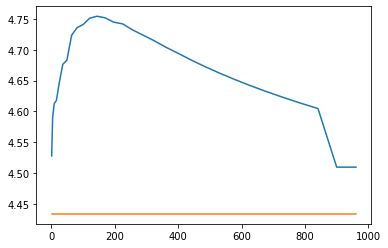

In [86]:
plt.plot(rank, [value.detach().numpy() for value in y])
plt.plot(rank, [evaluate_policy(ipw_policy, n=100000).detach().numpy()] * len(rank))

In [87]:
r = torch.as_tensor(Y) * ipw_prob
rank = [j ** 2 for j in range(1, 32)]
y_hard = []
for i in tqdm.tqdm(rank):
    y_hard.append(confoundingRobustKernel(r, T, X, a, b, p_t, rank_constraints=i, hard_constraint=True))

100%|█████████████████████████████████████████████████| 31/31 [05:58<00:00, 11.56s/it]


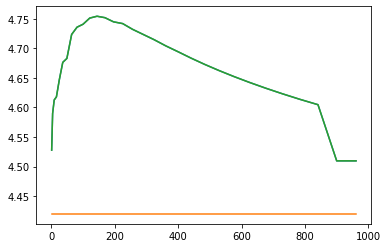

In [88]:
plt.plot(rank, [value.detach().numpy() for value in y])
plt.plot(rank, [evaluate_policy(ipw_policy, n=100000).detach().numpy()] * len(rank))
plt.plot(rank, [value.detach().numpy() for value in y_hard])

In [89]:
Y.std() / 1000 ** 0.5

0.09274408626053594

#### Compare Policy Improvement

In [90]:
evaluate_policy(base_policy, n=100000)

tensor(3.7545, dtype=torch.float64)

In [91]:
# Hajek policy improvement
train_steps = 101
beta_hajek = torch.zeros(6, requires_grad=True, dtype=float)
hajek_policy = lambda X: LR_policy(X, beta_hajek)
optimizer = torch.optim.RMSprop(lr=1e-1, params=[beta_hajek])
# hajek_policy = nnPolicy()
# optimizer = torch.optim.Adam(lr=3e-2, params=hajek_policy.parameters(), weight_decay=0.01)
pbar = tqdm.tqdm(range(train_steps))
for i in pbar:
    # base_prob =  0.5 * good_policy(X) * torch.tensor(T) + (1 - 0.5 * good_policy(X)) * torch.tensor(1 - T)
    base_prob =  base_policy(X) * torch.tensor(T) + (1 - base_policy(X)) * torch.tensor(1 - T)
    hajek_prob = hajek_policy(X) * torch.tensor(T) + (1 - hajek_policy(X)) * torch.tensor(1 - T)
    r = torch.tensor(Y) * (hajek_prob - base_prob)
    hajek_improvement, w = confoundingRobustHajek(r, T, a, b, return_w=True)
    (- hajek_improvement).backward()
    optimizer.step()
    optimizer.zero_grad()
    pbar.set_description(f"Improvement: {hajek_improvement}")

Improvement: 0.8412939156118103: 100%|██████████████| 101/101 [00:02<00:00, 40.45it/s]


In [92]:
evaluate_policy(hajek_policy, n=100000)

tensor(4.4639, dtype=torch.float64, grad_fn=<MeanBackward0>)

In [93]:
# Kernel policy improvement
train_steps = 101
beta_kernel = torch.zeros(6, requires_grad=True, dtype=float)
kernel_policy = lambda X: LR_policy(X, beta_kernel)
optimizer = torch.optim.RMSprop(lr=1e-1, params=[beta_kernel])
# kernel_policy = nnPolicy()
# optimizer = torch.optim.Adam(lr=3e-2, params=kernel_policy.parameters(), weight_decay=0.01)
pbar = tqdm.tqdm(range(train_steps))
for i in pbar:
    base_prob =  base_policy(X) * torch.tensor(T) + (1 - base_policy(X)) * torch.tensor(1 - T)
    kernel_prob = kernel_policy(X) * torch.tensor(T) + (1 - kernel_policy(X)) * torch.tensor(1 - T)
    r = torch.tensor(Y) * (kernel_prob - base_prob)
    kernel_improvement, w = confoundingRobustKernel(r, T, X, a, b, p_t, lambd, kernel, return_w=True, use_hajek_constraints=False)
    (- kernel_improvement).backward()
    optimizer.step()
    optimizer.zero_grad()
    pbar.set_description(f"Improvement: {kernel_improvement}")

Improvement: 0.9907096748300198: 100%|██████████████| 101/101 [00:59<00:00,  1.70it/s]


In [94]:
evaluate_policy(kernel_policy, n=100000)

tensor(4.4334, dtype=torch.float64, grad_fn=<MeanBackward0>)

In [95]:
# Kernel policy improvement
train_steps = 101
beta_kernel = torch.zeros(6, requires_grad=True, dtype=float)
kernel_policy = lambda X: LR_policy(X, beta_kernel)
optimizer = torch.optim.RMSprop(lr=1e-1, params=[beta_kernel])
# kernel_policy = nnPolicy()
# optimizer = torch.optim.Adam(lr=3e-2, params=kernel_policy.parameters(), weight_decay=0.01)
pbar = tqdm.tqdm(range(train_steps))
for i in pbar:
    base_prob =  base_policy(X) * torch.tensor(T) + (1 - base_policy(X)) * torch.tensor(1 - T)
    kernel_prob = kernel_policy(X) * torch.tensor(T) + (1 - kernel_policy(X)) * torch.tensor(1 - T)
    r = torch.tensor(Y) * (kernel_prob - base_prob)
    kernel_improvement, w = confoundingRobustKernel(r, T, X, a, b, p_t, lambd, kernel, return_w=True)
    (- kernel_improvement).backward()
    optimizer.step()
    optimizer.zero_grad()
    pbar.set_description(f"Improvement: {kernel_improvement}")

Improvement: 1.0272390629886947: 100%|██████████████| 101/101 [01:03<00:00,  1.58it/s]


In [96]:
evaluate_policy(kernel_policy, n=100000)

tensor(4.4486, dtype=torch.float64, grad_fn=<MeanBackward0>)

### Just run min-max optimzation

In [112]:
# Hajek policy min-max value
train_steps = 101
beta_hajek = torch.zeros(6, requires_grad=True, dtype=float)
hajek_policy = lambda X: LR_policy(X, beta_hajek)
optimizer = torch.optim.RMSprop(lr=1e-1, params=[beta_hajek])
# NN seems to overfit
# hajek_policy = nnPolicy()
# hajek_policy = ipw_policy  # degrades the ipw policy
# optimizer = torch.optim.Adam(lr=1e-2, params=hajek_policy.parameters(), weight_decay=0.01)
pbar = tqdm.tqdm(range(train_steps))
for i in pbar:
    hajek_prob = hajek_policy(X) * torch.tensor(T) + (1 - hajek_policy(X)) * torch.tensor(1 - T)
    r = torch.tensor(Y) * hajek_prob
    hajek_value, w = confoundingRobustHajek(r, T, a, b, return_w=True)
    (- hajek_value).backward()
    optimizer.step()
    optimizer.zero_grad()
    pbar.set_description(f"Value: {hajek_value}")

Value: 4.5913103168639: 100%|███████████████████████| 101/101 [00:02<00:00, 39.54it/s]


In [113]:
evaluate_policy(hajek_policy, n=100000)

tensor(4.6923, dtype=torch.float64, grad_fn=<MeanBackward0>)

In [114]:
est = confoundingRobustKernel(r, T, X, a, b, p_t, lambd, kernel)
est

tensor(4.7703, dtype=torch.float64, grad_fn=<MeanBackward0>)

In [100]:
# Kernel policy min-max value
train_steps = 101
beta_kernel = torch.zeros(6, requires_grad=True, dtype=float)
kernel_policy = lambda X: LR_policy(X, beta_kernel)
optimizer = torch.optim.RMSprop(lr=1e-1, params=[beta_kernel])
# kernel_policy = nnPolicy()
# optimizer = torch.optim.Adam(lr=3e-2, params=kernel_policy.parameters(), weight_decay=0.01)
pbar = tqdm.tqdm(range(train_steps))
for i in pbar:
    kernel_prob = kernel_policy(X) * torch.tensor(T) + (1 - kernel_policy(X)) * torch.tensor(1 - T)
    r = torch.tensor(Y) * kernel_prob
    kernel_value, w = confoundingRobustKernel(r, T, X, a, b, p_t, lambd, kernel, return_w=True, use_hajek_constraints=False)
    (- kernel_value).backward()
    optimizer.step()
    optimizer.zero_grad()
    pbar.set_description(f"Value: {kernel_value}")

Value: 4.732229328016516: 100%|█████████████████████| 101/101 [01:05<00:00,  1.55it/s]


In [101]:
evaluate_policy(kernel_policy, n=100000)

tensor(4.7411, dtype=torch.float64, grad_fn=<MeanBackward0>)

In [102]:
# Kernel policy min-max value
train_steps = 101
beta_kernel = torch.zeros(6, requires_grad=True, dtype=float)
kernel_policy = lambda X: LR_policy(X, beta_kernel)
optimizer = torch.optim.RMSprop(lr=1e-1, params=[beta_kernel])
# kernel_policy = nnPolicy()
# optimizer = torch.optim.Adam(lr=3e-2, params=kernel_policy.parameters(), weight_decay=0.01)
pbar = tqdm.tqdm(range(train_steps))
for i in pbar:
    kernel_prob = kernel_policy(X) * torch.tensor(T) + (1 - kernel_policy(X)) * torch.tensor(1 - T)
    r = torch.tensor(Y) * kernel_prob
    kernel_value, w = confoundingRobustKernel(r, T, X, a, b, p_t, lambd, kernel, return_w=True)
    (- kernel_value).backward()
    optimizer.step()
    optimizer.zero_grad()
    pbar.set_description(f"Value: {kernel_value}")

Value: 4.723453506778068: 100%|█████████████████████| 101/101 [01:06<00:00,  1.51it/s]


In [103]:
evaluate_policy(kernel_policy, n=100000)

tensor(4.7271, dtype=torch.float64, grad_fn=<MeanBackward0>)

### Conclusions
- The difference in performance is sample-dependent
  - If the sample is well confounded, then kernel + hajek tends to be better than hajek
- IPW estimator is good enough in most cases, so we might not actually need confounding-robust methods
- Still, kernel + hajek method offers better lower-bound of the policy value, so it must have some use cases.

### Make a Table for Slide

In [ ]:
pi1 = lambda x: 0.5
pi2 = toy_policy
pi3 = best_policy
pi4 = hajek_policy
pi5 = kernel_policy
pi6 = ipw_policy

In [ ]:
table = {}
for i, pi in tqdm.tqdm(enumerate([pi1, pi2, pi3, pi4, pi5, pi6])):
    table[f"$\\pi_{i+1}$"] = row = {}
    row['$V_\\text{inf}$'] = float(evaluate_policy(pi, n=100000))
    prob = pi(X) * torch.tensor(T) + (1 - pi(X)) * torch.tensor(1 - T)
    r = torch.tensor(Y) * prob
    row['$\\hat V_\\text{inf}^\\Hajek$'] = float(confoundingRobustHajek(r, T, a, b))
    row['$\\hat V_\\text{inf}^\\kernel$'] = float(confoundingRobustKernel(r, T, X, a, b, p_t))
    row['$\\hat V_\\text{inf}^\\text{IPW}$'] = float(IPW(r, p_t))

In [ ]:
table_copy = table.copy()
table.pop("$\\pi_6$")

In [ ]:
print("\\begin{tabular}{ | m{4em} || " + "m{3em} " * len(table) + "| }")
print("\\hline")
header = "{}\t" + "&{}\t" * len(table) + "\\\\"
print(header.format("", *table.keys()))
print("\\hline")

row_names = table["$\\pi_1$"].keys()
for row in row_names:
    s = "{}\t" + "&{:1.3f}\t" * len(table) + "\\\\"
    print(s.format(row, *[col[row] for col in table.values()]))
    print("\\hline")
print("\\end{tabular}")


### Estimate Propensity Score (Conditional Density Estimation)
- This requires consistent nominal propensity score (p_obs(t|x))
- For discrete t, just run kernel logistic regressionregret_kernel

#### Discrete Case

In [ ]:
from sklearn.linear_model import LogisticRegressionCV
# from sklearn.metrics import roc_auc_score, make_scorer
# roc_auc_score = make_scorer(roc_auc_score, greater_is_better=True, needs_proba=True)

model = LogisticRegressionCV().fit(X, T)
e_xx = model.predict_proba(X)[:, 1]

np.mean(np.abs(e_xx - e_x))

In [ ]:
import optuna
from sklearn.decomposition import KernelPCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

def objective(trial):
    gamma = trial.suggest_float('gamma', 1e-2, 1e+2, log=True)
    lambd = trial.suggest_float('lambd', 1e-3, 1e+3, log=True)
    model = Pipeline([
        ('kpca', KernelPCA(n_components=100, kernel='rbf', gamma=gamma)),
        ('LogReg', LogisticRegression(C=1/lambd)),
    ])   
    cv_scores = cross_val_score(model, X, y=T, cv=4)
    return cv_scores.mean()

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(func=objective, n_trials=100)

In [ ]:
study.best_params

In [ ]:
Z = KernelPCA(n_components=200, kernel='rbf', gamma=0.01).fit_transform(X)
model = LogisticRegression(C=5).fit(Z, T)
e_xx = model.predict_proba(Z)[:, 1]

np.mean(np.abs(e_xx - e_x))

In [ ]:
np.mean(1 / e_x * T), np.mean(1 / (1 - e_x) * (1 - T)), # both should be 1

In [ ]:
np.mean(1 / e_xx * T), np.mean(1 / (1 - e_xx) * (1 - T)), # both should be 1

#### Continuous Case (Maybe on the next notebook)

In [ ]:
from statsmodels.nonparametric.kernel_density import KDEMultivariateConditional

In [ ]:
EPS = 1e-6

def benchmark_bandwidth(bw, T, X, cv=5):
    n = T.shape[0]
    indep_type='c' * X.shape[1]
    dep_type='u'
    split = (np.arange(n) % 5)
    cross_entropy = 0
    for i in range(cv):
        train = (split != i)
        test = (split == i)
        model = KDEMultivariateConditional(T[train, None], X[train, :], dep_type='c', indep_type='c' * X.shape[1], bw=bw)
        cross_entropy += np.mean(model.pdf(T[test, None], X[test, :]) + EPS) / cv
    return cross_entropy

In [ ]:
best_scale = 0
best_score = - float('inf')
for scale in [0.1, 0.2, 0.3, 0.5, 0.7, 1, 1.5, 2, 3, 5]:
    bw = scale * np.concatenate([[Y.std()], X.std(axis=0)]) / Y.shape[0] ** (1 / 7)
    score = benchmark_bandwidth(bw, Y, X)
    if score > best_score:
        best_scale = scale
        best_score = score

In [ ]:
best_scale, best_score

In [ ]:
bw0 = best_scale * np.concatenate([[Y.std()], X.std(axis=0)]) / Y.shape[0] ** (1 / 7)
model = KDEMultivariateConditional(Y[:, None], X, dep_type='c', indep_type='c' * X.shape[1], bw=bw0)

In [ ]:
e_xx = model.pdf(Y[:, None], X)
e_xx

In [ ]:
plt.hist(e_xx)

In [ ]:
model.bw

In [ ]:
[np.mean(1. / e_xx * ((i <= Y) & (Y <= i + 1))) for i in range(7)]  # Should go to 1

In [ ]:
# Shouldn't we use loo estimate for propensity? (For reducing the sampling bias)

In [ ]:
model_loocv = KDEMultivariateConditional(Y[:500, None], X[:500], dep_type='c', indep_type='c' * X.shape[1], bw='cv_ml')
model_loocv = KDEMultivariateConditional(Y[:, None], X, dep_type='c', indep_type='c' * X.shape[1], bw=model_loocv.bw)
model_loocv.pdf(T[:, None], X)

In [ ]:
model_loocv.bw

In [ ]:
e_xx = model_loocv.pdf(Y[:, None], X)
e_xx

In [ ]:
[np.mean(1. / e_xx * ((i <= Y) & (Y <= i + 1))) for i in range(7)]  # Should go to 1

In [ ]:
Y, T, X, U, e_x, e_xu = generate_data(2000)

In [ ]:
# Maybe better to use gaussian process regression
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, WhiteKernel, RBF
from scipy.stats import norm

kernel = WhiteKernel() + ConstantKernel() * RBF()
model = GaussianProcessRegressor(kernel=kernel).fit(X, Y)
mu, sigma = model.predict(X, return_std=True)
e_xx = norm.pdf(Y, loc=mu, scale=sigma)

In [ ]:
plt.hist(e_xx)

In [ ]:
[np.mean(1. / e_xx * ((i <= Y) & (Y <= i + 1))) for i in range(7)]  # Should go to 1